In [5]:
!ls ../data/ruLibriSpeech

ruls_data.tar.gz


### extract tar

In [6]:
import tarfile

In [8]:
tar_path = "../data/ruLibriSpeech/ruls_data.tar.gz"
target_path = "../data/ruLibriSpeech/ruls_data/"

with tarfile.open(tar_path) as f:
    f.extractall(target_path)
    f.close()

### try to play audio

In [9]:
import torchaudio

In [10]:
path = "../data/ruLibriSpeech/ruls_data/dev/audio/5397/2145/poemi_12_pushkin_0000.wav"
wav, sr = torchaudio.load(path)

In [11]:
from IPython import display

In [12]:
display.Audio(wav, rate=sr)

In [46]:
sr

16000

In [16]:

# average all channels -> mono convertion
if wav.dim() == 2:
    wav = wav.mean(dim=0)
    

In [18]:
from matplotlib import pyplot as plt

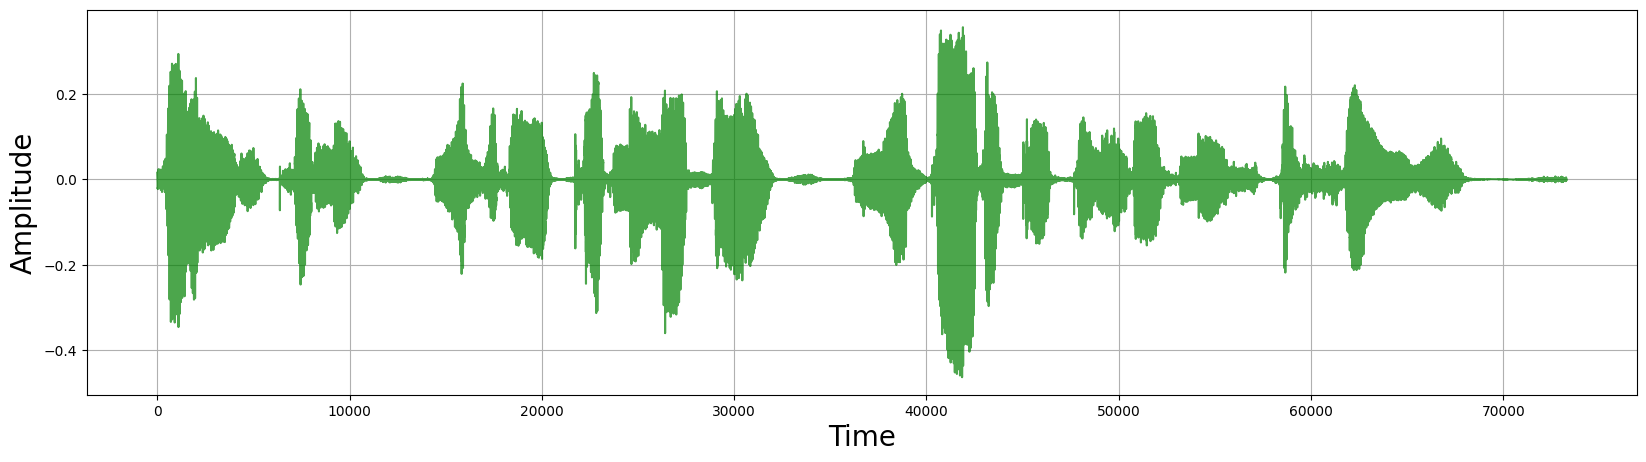

In [19]:
plt.figure(figsize=(20, 5))
plt.plot(wav, alpha=.7, c='green')
plt.grid()
plt.xlabel('Time', size=20)
plt.ylabel('Amplitude', size=20)
plt.show()

display.display(display.Audio(wav, rate=sr))

In [ ]:
# FFT

In [21]:
import torch

In [22]:
n_fft = 1024 # first 1024 samples
#  Since our signal is real, we will use rfft and the size of the output spectrum will be n_fft // 2 + 1.
spectrum = torch.fft.rfft(wav, n=n_fft)


In [23]:
spectrum.dtype

torch.complex64

In [24]:
# complex to modules
spectrogram = spectrum.abs().pow(2)


In [25]:
spectrogram_v2 = torch.view_as_real(spectrum).norm(dim=-1).pow(2)

In [26]:
assert torch.allclose(spectrogram, spectrogram_v2)

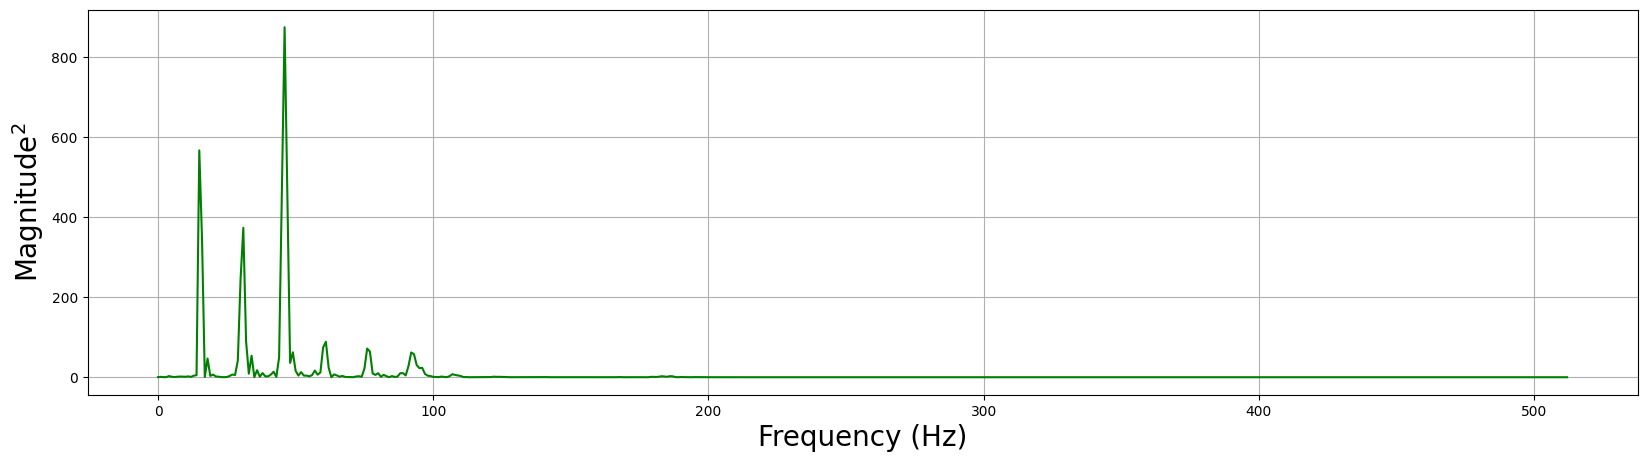

In [27]:
plt.figure(figsize=(20, 5))
plt.plot(spectrogram.squeeze(), c='green')
plt.grid()
plt.xlabel('Frequency (Hz)', size=20)
plt.ylabel('Magnitude$^2$', size=20)
plt.show()

In [ ]:
# Hann window function

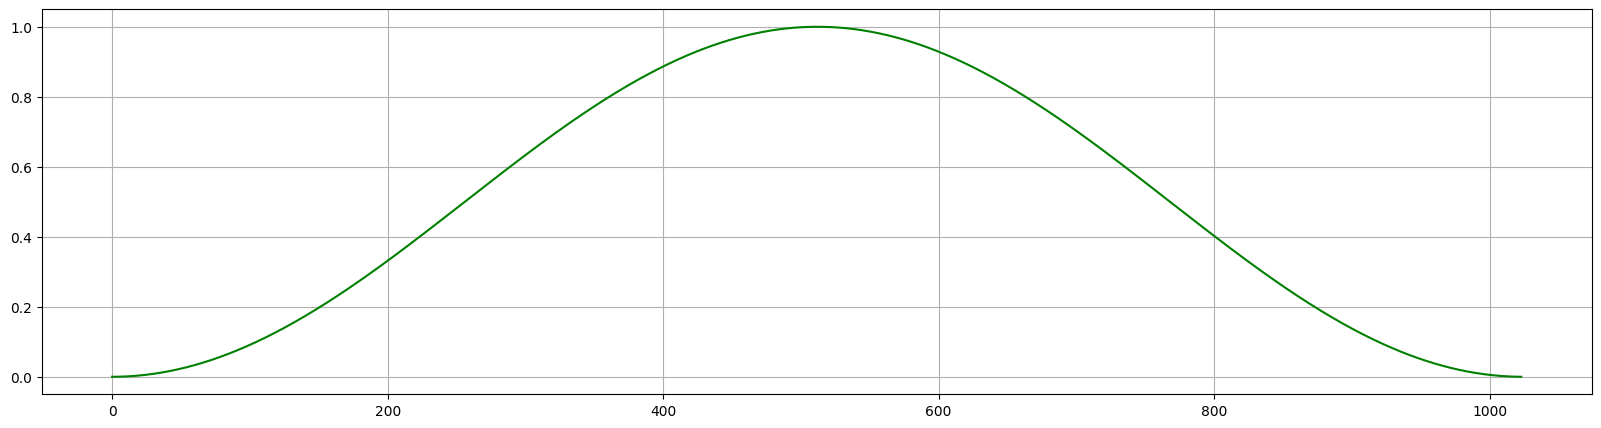

In [28]:
window_size = n_fft
window = torch.hann_window(window_size)

plt.figure(figsize=(20, 5))
plt.plot(window, c='green')
plt.grid()
plt.show()

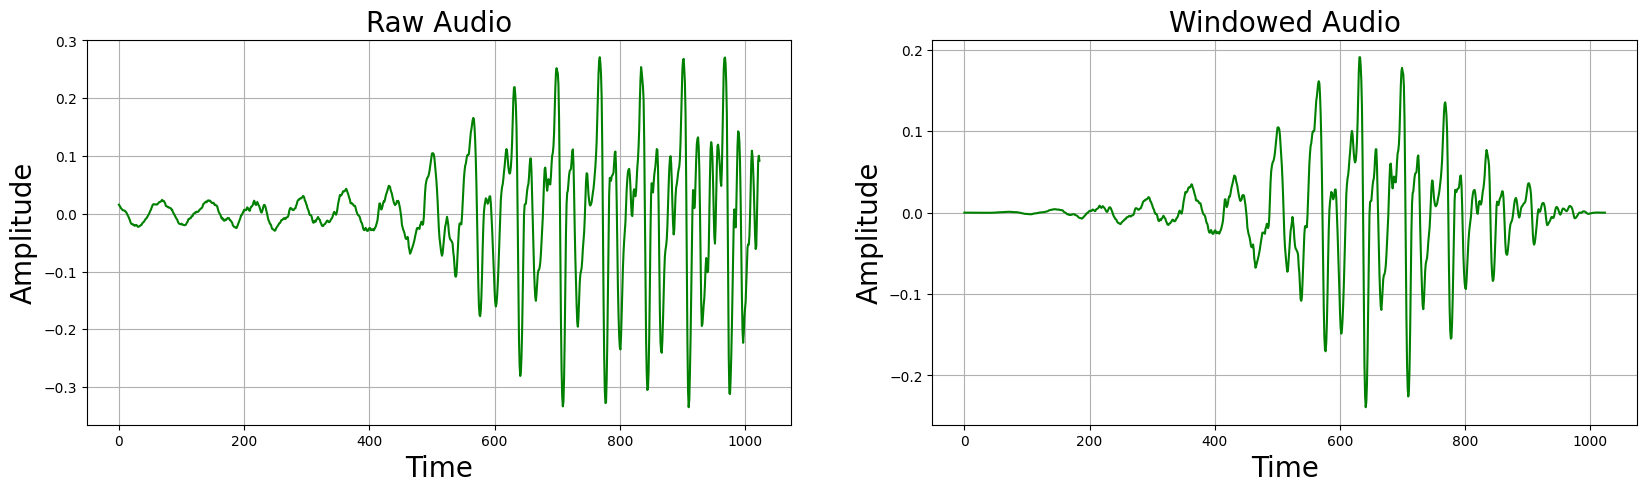

In [30]:
clipped_wav = wav[:window_size]
windowed_clipped_wav = window * clipped_wav

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(clipped_wav.squeeze(), c='green')
axes[0].set_title('Raw Audio', size=20)

axes[1].plot(windowed_clipped_wav.squeeze(), c='green')
axes[1].set_title('Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Time', size=20)
    axes[i].set_ylabel('Amplitude', size=20)

plt.show()

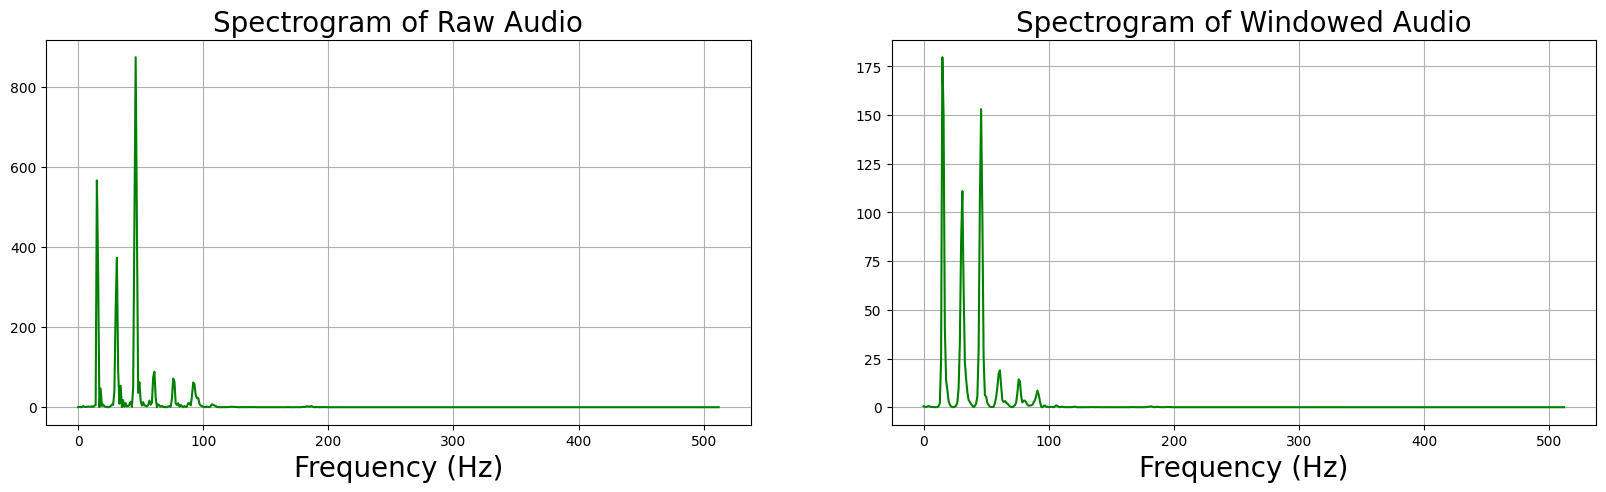

In [31]:
spectrogram = torch.fft.rfft(clipped_wav).abs().pow(2)
windowed_spectrogram = torch.fft.rfft(windowed_clipped_wav).abs().pow(2)

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

axes[0].plot(spectrogram.squeeze(), c='green')
axes[0].set_title('Spectrogram of Raw Audio', size=20)

axes[1].plot(windowed_spectrogram.squeeze(), c='green')
axes[1].set_title('Spectrogram of Windowed Audio', size=20)

for i in range(2):
    axes[i].grid()
    axes[i].set_xlabel('Frequency (Hz)', size=20)

plt.show()

In [ ]:
# STFT (Short-time Fourier transform)

In [32]:
n_fft = 1024
window_size = n_fft
hop_size = 256
window = torch.hann_window(n_fft)

In [33]:
spectrum = torch.stft(
    wav,
    n_fft=n_fft,
    hop_length=hop_size,
    win_length=window_size,
    window=window,
    
    # We don't want to pad input signal
    center=False,
    
    # Take first (n_fft // 2 + 1) frequencies
    onesided=True,
    
    # Apply torch.view_as_real on each window
    return_complex=False, 
)

In [34]:
spectrum.shape

torch.Size([513, 283, 2])

In [35]:
spectrogram = spectrum.norm(dim=-1).pow(2)
spectrogram.shape

torch.Size([513, 283])

The last dimension of spectrogram is time. Each timestamp is called frame Now let's visualize the spectrogram for the whole wav.

Note that to compress the range of spectrogram values, we will apply the element-wise log. It is classic spectrogram prepreprocessing.

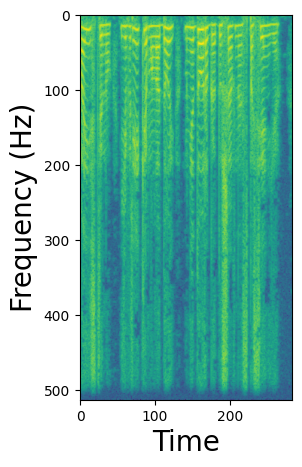

In [36]:
plt.figure(figsize=(20, 5))
plt.imshow(spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Frequency (Hz)', size=20)
plt.show()

The last stage is Mel Scale. First of all, let's take a close look to Mel Scale and then apply it to our spectogram.

To initialise Mel Scale we will use torchaudio.

In [37]:
mel_scaler = torchaudio.transforms.MelScale(
    n_mels=80,
    sample_rate=22_050,
    n_stft=n_fft // 2 + 1
)

Mel Scale is nothing more than rectangle matrix. We will multiply each frame in spectrogram by mel_scaler.fb matrix.

In [38]:
mel_scaler.fb.shape

torch.Size([513, 80])

In [39]:
mel_scaler.fb.T

tensor([[-0.0000, 0.8688, 0.2876,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.7124,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.1074, 0.0537, 0.0000]])

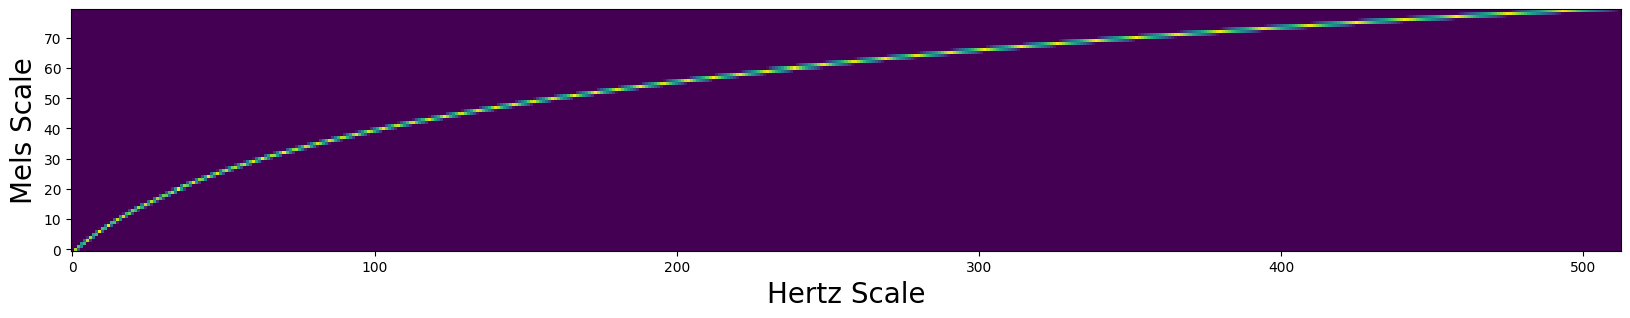

In [40]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_scaler.fb.T)
plt.xlabel('Hertz Scale', size=20)
plt.ylabel('Mels Scale', size=20)
plt.gca().invert_yaxis()
plt.show()

In [41]:
mel_spectrogram = mel_scaler(spectrogram)

In [42]:
mel_spectrogram.shape

torch.Size([80, 283])

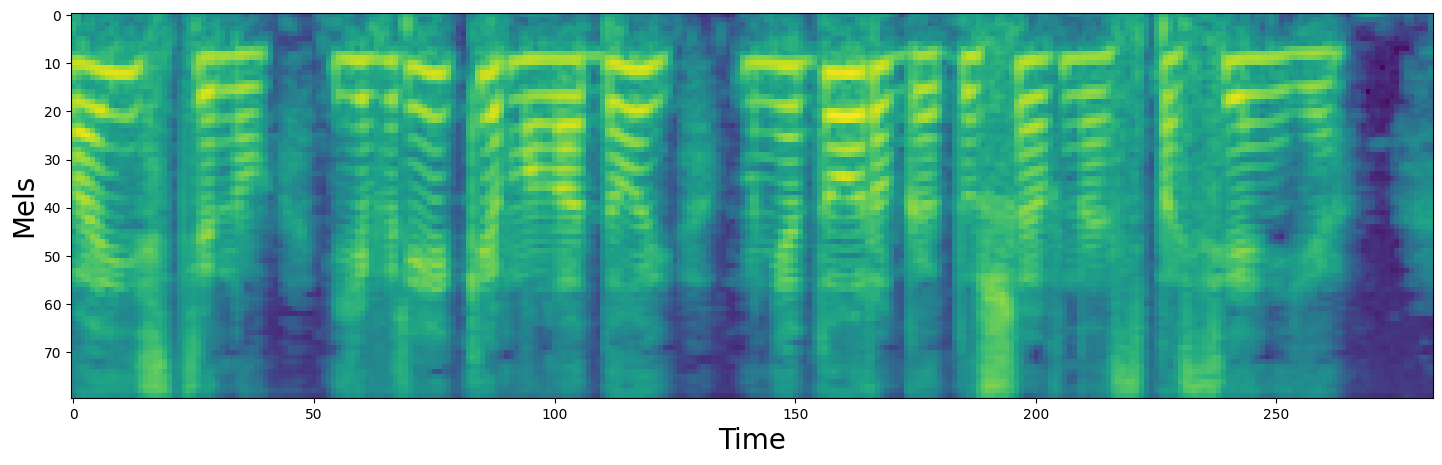

In [43]:
plt.figure(figsize=(20, 5))
plt.imshow(mel_spectrogram.squeeze().log())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In general, we can use MelSpectrogram from torchaudio which combine window, stft, spectrogram and mel calculation.

In [44]:
featurizer = torchaudio.transforms.MelSpectrogram(
    sample_rate=22_050,
    n_fft=1024,
    win_length=1024,
    hop_length=256,
    n_mels=80,
    window_fn=torch.hann_window,
    center=False
)

In [45]:
assert torch.allclose(mel_spectrogram, featurizer(wav))